In [1]:
# Necessary libraries
import os
import sys
import pandas as pd
from datetime import datetime, timedelta
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:

sys.path.append("/home/khanalp/code/PhD")
from utils.utils import read_csv_file_with_station_name

In [3]:
# All the paths 
path_resistance_check = "/home/khanalp/testcase/"
# Path to CSV file containing station details (name, latitude, longitude, etc.)
path_station_details = "/home/khanalp/code/PhD/preprocessICOSdata/csvs/02_station_with_elevation_heightcanopy.csv"
path_insitu_flux = "/home/khanalp/data/processed/insituflux_with_qc"
path_insitu_forcing = "/home/khanalp//data/processed/input_pystemmus/testcase"
ICOS_location = "/home/khanalp/data/ICOS2020"
path_model_output = "/home/khanalp/data/processed/output_pystemmus/"

In [4]:
# Station of interest
station_name = "DE-Tha"

In [5]:
# Read station details
df_station_details = pd.read_csv(path_station_details)


In [6]:
base_version = "v0"
new_version = "vMay12"
# v2_version = "v5"
fluxes_filename = "fluxes.csv"
resistance_filename = "output_resistances.csv"
rac_filename = "rac.csv"
rbc_filename = "rbc.csv"

In [7]:
start_time = pd.to_datetime("2005-06-01 00:00:00")
end_time = pd.to_datetime("2005-07-31 23:30:00")

# For ICOS flux data

In [8]:
# For reading insitu file
def select_rename_convert_to_xarray(data_frame, selected_variables, rename_mapping):
    """
    Selects required variables from ICOS data, renames them, and converts to xarray dataset.

    Parameters:
        data_frame (pandas.DataFrame): DataFrame containing ICOS data.
        selected_variables (list): List of variables to select from the DataFrame.
        rename_mapping (dict): Dictionary containing renaming mapping for variables.

    Returns:
        xarray.Dataset: Processed ICOS data as an xarray dataset.
    """
    # Initialize an empty DataFrame to hold selected variables
    df_selected = pd.DataFrame()
    
    # Iterate over the list of selected variables
    for var in selected_variables:
        # Check if the variable exists in the input DataFrame
        if var in data_frame.columns:
            # If the variable exists, add it to the df_selected DataFrame
            df_selected[var] = data_frame[var]
        else:
            # If the variable does not exist, add it with missing values (-9999)
            df_selected[var] = np.full_like(data_frame.index, -9999)
            # Optional: Uncomment the line below to print a warning message
            # print(f"Variable '{var}' not found in the DataFrame. Adding it with missing values (-9999).")
    
    # Rename columns according to the provided mapping
    df_selected = df_selected.rename(columns=rename_mapping)
    
    # Convert the DataFrame to an xarray Dataset
    xds = xr.Dataset.from_dataframe(df_selected)
    
    # Assign datetime coordinates to the 'index' dimension based on the 'TIMESTAMP_START' column
    xds_indexed = xds.assign_coords(index=pd.to_datetime(xds['TIMESTAMP_START'], format='%Y%m%d%H%M'))
    
    # Rename the 'index' dimension to 'time'
    xds_indexed = xds_indexed.rename({'index': 'time'})
    
    # Expand dimensions to include 'x' and 'y' coordinates with dummy values
    xds_dimension = xds_indexed.expand_dims({'x': [1], 'y': [2]})
    
    # Drop the 'TIMESTAMP_START' variable as it is no longer needed
    xds_dimension = xds_dimension.drop_vars('TIMESTAMP_START')
    
    # Ensure 'x' and 'y' coordinates are of type float64 for consistency
    xds_dimension['x'] = xds_dimension['x'].astype('float64')
    xds_dimension['y'] = xds_dimension['y'].astype('float64')
    
    # Return the final xarray Dataset with selected, renamed variables and added dimensions
    return xds_dimension



In [9]:
# Read the corresponding CSV file for the ICOS station in fluxnet format
df_insitu = read_csv_file_with_station_name(ICOS_location, station_name)


In [10]:
# Define the list of variables to select from ICOS data
selected_variables = [
    'TIMESTAMP_START',
    'TA_F',
    'TA_F_QC',
    'SW_IN_F',
    'SW_IN_F_QC',
    'LW_IN_F',
    'LW_IN_F_QC',
    'VPD_F',
    'VPD_F_QC',
    'PA_F',
    'PA_F_QC',
    'P_F',
    'P_F_QC',
    'WS_F',
    'WS_F_QC',
    'RH',
    'CO2_F_MDS',
    'CO2_F_MDS_QC',
    'USTAR'
]

# Define the mapping for renaming variables
rename_mapping = {
    'TA_F': 'Tair',
    'TA_F_QC': 'Tair_qc',
    'SW_IN_F': 'SWdown',
    'SW_IN_F_QC': 'SWdown_qc',
    'LW_IN_F': 'LWdown',
    'LW_IN_F_QC': 'LWdown_qc',
    'VPD_F': 'VPD',
    'VPD_F_QC': 'VPD_qc',
    'PA_F': 'Psurf',
    'PA_F_QC': 'Psurf_qc',
    'P_F': 'Precip',
    'P_F_QC': 'Precip_qc',
    'WS_F': 'Wind',
    'WS_F_QC': 'Wind_qc',
    'CO2_F_MDS': 'CO2air',
    'CO2_F_MDS_QC': 'CO2air_qc',
    'USTAR' : 'USTAR'
}

In [11]:
# Convert the DataFrame to xarray, selecting and renaming variables
ds_ICOS_full = select_rename_convert_to_xarray(df_insitu, selected_variables, rename_mapping)

In [12]:
ds_ICOS_full['USTAR'] = ds_ICOS_full.USTAR.where(ds_ICOS_full.USTAR != -9999, np.nan)

In [13]:
ds_ICOS_full_selected = ds_ICOS_full.sel(time=slice(start_time, end_time))

# For processed insitu flux and insitu forcing 

In [14]:
# Find file 
file_insitu_flux = [os.path.join(path_insitu_flux, f) for f in os.listdir(path_insitu_flux) if station_name in f]
file_insitu_forcing = [os.path.join(path_insitu_forcing, f) for f in os.listdir(path_insitu_forcing) if station_name in f]
file_model_output = [os.path.join(path_model_output, f) for f in os.listdir(path_model_output) if station_name in f]

In [15]:
# Open the .nc file
ds_insitu_flux = xr.open_dataset(file_insitu_flux[0])
ds_insitu_forcing = xr.open_dataset(file_insitu_forcing[0])
ds_model_output_basev = xr.open_dataset(file_model_output[0])

In [16]:
# Selecting the period of interest
ds_insitu_flux_selected = ds_insitu_flux.sel(time=slice(start_time, end_time))
ds_insitu_forcing_selected = ds_insitu_forcing.sel(time=slice(start_time, end_time))
ds_model_output_basev_selected = ds_model_output_basev.sel(time=slice(start_time, end_time))

In [17]:

folder_basev = [os.path.join(path_resistance_check, f,base_version) for f in os.listdir(path_resistance_check) if station_name in f]
folder_newv = [os.path.join(path_resistance_check, f,new_version) for f in os.listdir(path_resistance_check) if station_name in f]
# folder_v2v = [os.path.join(path_resistance_check, f,v2_version) for f in os.listdir(path_resistance_check) if station_name in f]

In [18]:
os.path.join(folder_newv[0], fluxes_filename)

'/home/khanalp/testcase/DE-Tha_2025-04-16-1631/vMay12/fluxes.csv'

In [19]:
folder_newv[0]

'/home/khanalp/testcase/DE-Tha_2025-04-16-1631/vMay12'

In [20]:
# Base and new version file name
df_fluxes_basev = pd.read_csv(os.path.join(folder_basev[0], fluxes_filename))
df_fluxes_newv = pd.read_csv(os.path.join(folder_newv[0], fluxes_filename))
# df_fluxes_v2v = pd.read_csv(os.path.join(folder_v2v[0], fluxes_filename))

In [21]:
os.path.join(folder_newv[0], fluxes_filename)

'/home/khanalp/testcase/DE-Tha_2025-04-16-1631/vMay12/fluxes.csv'

In [22]:
# Remove first row
df_fluxes_basev = df_fluxes_basev.iloc[1:,]
df_fluxes_newv = df_fluxes_newv.iloc[1:,]
# df_fluxes_v2v = df_fluxes_v2v.iloc[1:,]

In [23]:
#Make everything numeric
df_fluxes_basev = df_fluxes_basev.apply(pd.to_numeric, errors='coerce')
df_fluxes_newv = df_fluxes_newv.apply(pd.to_numeric, errors='coerce')
# df_fluxes_v2v = df_fluxes_v2v.apply(pd.to_numeric, errors='coerce')

In [24]:
folder_basev

['/home/khanalp/testcase/DE-Tha_2025-04-16-1631/v0']

In [25]:
#Resistances file 
# df_resistance_basev = pd.read_csv(os.path.join(folder_basev[0], resistance_filename))
df_resistance_newv = pd.read_csv(os.path.join(folder_newv[0], resistance_filename))
# df_resistance_v2v = pd.read_csv(os.path.join(folder_v2v[0], resistance_filename))

<Axes: xlabel='time'>

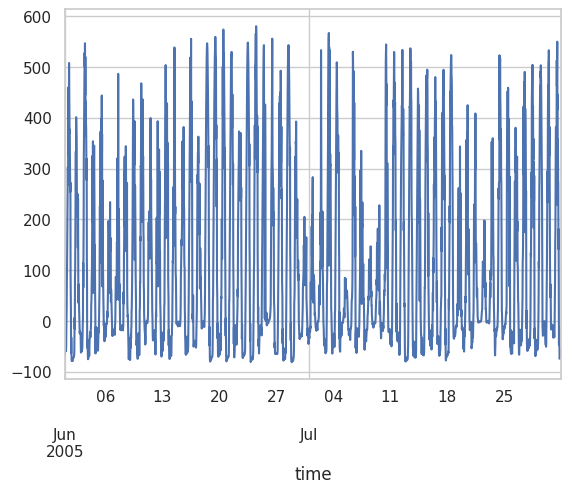

In [39]:
df_fluxes_newv.Rntot.plot()

In [27]:
# # Time index 
# df_resistance_newv['time'] = pd.to_datetime(ds_insitu_flux_selected.time.values.flatten())
# df_resistance_newv.set_index('time', inplace=True)

In [28]:
# Time index 
# df_resistance_v2v['time'] = pd.to_datetime(ds_ICOS_full_selected.time.values.flatten())
# df_resistance_v2v.set_index('time', inplace=True)

In [29]:
# df_resistance_basev = df_resistance_basev.drop_duplicates(subset=['KT'])

In [30]:
# df_resistance_basev['time'] = pd.to_datetime(ds_ICOS_full_selected.time.values.flatten())
# df_resistance_basev.set_index('time', inplace=True)

In [31]:
ds_insitu_flux_selected

<xarray.Dataset> Size: 562kB
Dimensions:     (x: 1, y: 1, time: 2928)
Coordinates:
  * x           (x) float64 8B 1.0
  * y           (y) float64 8B 2.0
  * time        (time) datetime64[ns] 23kB 2005-06-01 ... 2005-07-31T23:30:00
Data variables: (12/23)
    Rnet        (x, y, time) float64 23kB ...
    Rnet_qc     (x, y, time) float64 23kB ...
    SWup        (x, y, time) float64 23kB ...
    Qle         (x, y, time) float64 23kB ...
    Qle_qc      (x, y, time) float64 23kB ...
    Qh          (x, y, time) float64 23kB ...
    ...          ...
    GPP         (x, y, time) float64 23kB ...
    GPP_se      (x, y, time) float64 23kB ...
    GPP_DT      (x, y, time) float64 23kB ...
    GPP_DT_se   (x, y, time) float64 23kB ...
    Resp        (x, y, time) float64 23kB ...
    Resp_se     (x, y, time) float64 23kB ...

In [32]:
# df_fluxes_v2v['time'] = pd.to_datetime(ds_ICOS_full_selected.time.values.flatten())
# df_fluxes_v2v.set_index('time', inplace=True)
df_fluxes_newv['time'] = pd.to_datetime(ds_insitu_flux_selected.time.values.flatten())
df_fluxes_newv.set_index('time', inplace=True)
df_fluxes_basev['time'] = pd.to_datetime(ds_insitu_flux_selected.time.values.flatten())
df_fluxes_basev.set_index('time', inplace=True)

# I want to look only on the July week

In [33]:
start_time_poi = pd.to_datetime("2005-07-12 00:00:00")
end_time_poi = pd.to_datetime("2005-07-19 23:30:00")

In [34]:
# Select one week in July 2013
df_fluxes_basev_poi = df_fluxes_basev.loc[start_time_poi:end_time_poi]
# Select one week in July 2013
df_fluxes_newv_poi = df_fluxes_newv.loc[start_time_poi:end_time_poi]
# df_fluxes_v2v_poi = df_fluxes_v2v.loc[start_time_poi:end_time_poi]
# df_resistance_basev_poi = df_resistance_basev.loc[start_time_poi:end_time_poi]
# df_resistance_newv_poi = df_resistance_newv.loc[start_time_poi:end_time_poi]
# df_resistance_v2v_poi = df_resistance_v2v.loc[start_time_poi:end_time_poi]
ds_insitu_flux_poi = ds_insitu_flux_selected.sel(time=slice(start_time_poi, end_time_poi))
ds_ICOS_full_poi = ds_ICOS_full_selected.sel(time=slice(start_time_poi, end_time_poi))
ds_model_output_basev_poi = ds_model_output_basev_selected.sel(time=slice(start_time_poi, end_time_poi))


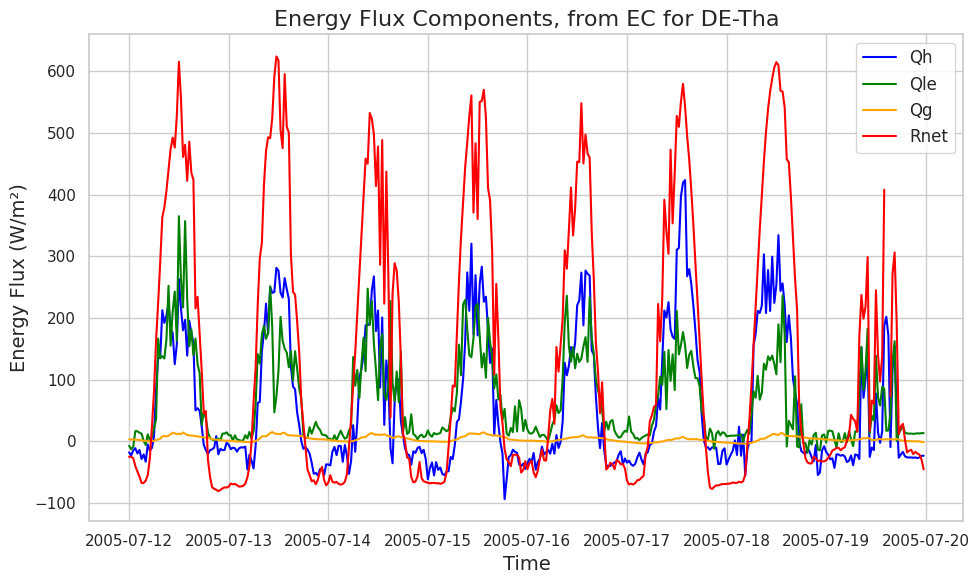

In [35]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_insitu_flux_poi.time.values, ds_insitu_flux_poi['Qh'].values.flatten(), label='Qh', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, ds_insitu_flux_poi['Qle'].values.flatten(), label='Qle', color='green', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, ds_insitu_flux_poi['Qg'].values.flatten(), label='Qg', color='orange', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, ds_insitu_flux_poi['Rnet'].values.flatten(), label='Rnet', color='red', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Flux (W/m²)', fontsize=14)
plt.title(f'Energy Flux Components, from EC for {station_name}', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
df_fluxes_newv_poi.columns

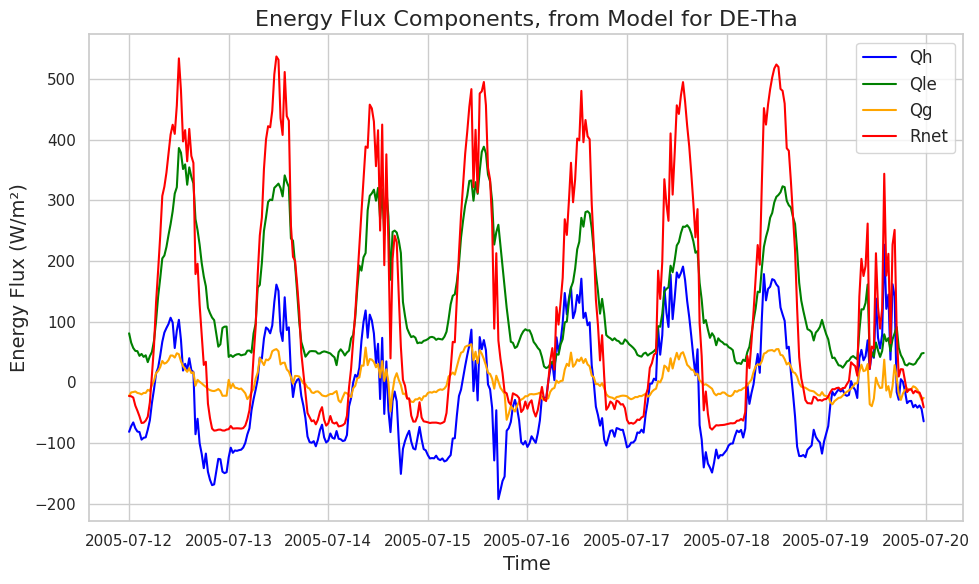

In [36]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df_fluxes_newv_poi.index.values, df_fluxes_newv_poi['Htot'].values.flatten(), label='Qh', color='blue', linewidth=1.5)
plt.plot(df_fluxes_newv_poi.index.values, df_fluxes_newv_poi['lEtot'].values.flatten(), label='Qle', color='green', linewidth=1.5)
plt.plot(df_fluxes_newv_poi.index.values, df_fluxes_newv_poi['Gtot'].values.flatten(), label='Qg', color='orange', linewidth=1.5)
plt.plot(df_fluxes_newv_poi.index.values, df_fluxes_newv_poi['Rntot'].values.flatten(), label='Rnet', color='red', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Flux (W/m²)', fontsize=14)
plt.title(f'Energy Flux Components, from Model for {station_name}', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()



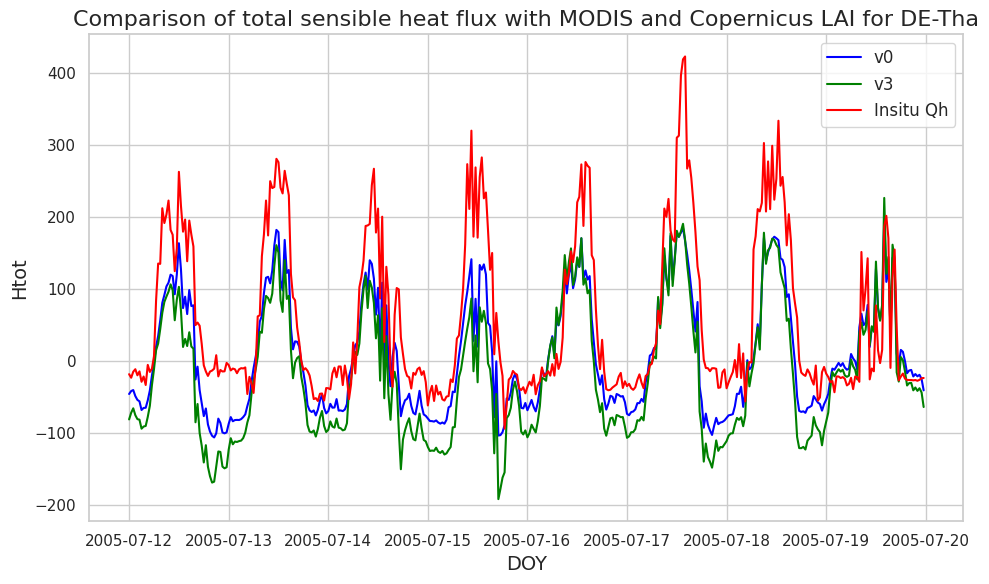

In [37]:

# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))


# Plot the data

plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_basev_poi['Htot'], label='v0', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_newv_poi['Htot'], label='v3', color='green', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, ds_insitu_flux_poi['Qh'].values.flatten(),color ='red', label='Insitu Qh')
# plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_v2v_poi['Htot'], label='v2', color='yellow', linewidth=1.5)


# Add labels, title, and legend

plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title(f'Comparison of total sensible heat flux with MODIS and Copernicus LAI for {station_name}', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_fluxes_newv_poi.columns

In [ ]:

# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data

plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_basev_poi['lEtot'], label='vo', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_newv_poi['lEtot'], label='v3', color='green', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, ds_insitu_flux_poi['Qle'].values.flatten(),color ='red', label='Insitu Qh')
# plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_v2v_poi['Htot'], label='v2', color='yellow', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title(f'Comparison of total latent flux with Copernicus and MODIS LAI for {station_name}', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_basev_poi['Hctot'], label='v0', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_newv_poi['Hctot'], label='v1', color='green', linewidth=1.5)
# plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_v2v_poi['Hctot'], label='v2', color='yellow', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Comparison of total canopy heat flux between v0 and v1', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_basev_poi['Hstot'], label='v0', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_newv_poi['Hstot'], label='v1', color='green', linewidth=1.5)
# plt.plot(ds_insitu_flux_poi.time.values, ds_insitu_flux_poi['Qg'].values.flatten(),color ='red', label='Insitu Qh')
# plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_v2v_poi['Hstot'], label='v2', color='yellow', linewidth=1.5)


# Add labels, title, and legend
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Comparison of total soil heat flux between v0,v1', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ds_model_output_basev_poi

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_model_output_basev_poi.time.values, ds_model_output_basev_poi['VegT'].values.flatten(), label='v0', color='blue', linewidth=1.5)
plt.plot(df_resistance_newv_poi.index.values, df_resistance_newv_poi['Tcave'], label='v1', color='green', linewidth=1.5)
plt.plot(ds_ICOS_full_poi.time.values,ds_ICOS_full_poi['Tair'].values.flatten(),color ='red', label='Insitu Ta')
# plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_v2v_poi['Hstot'], label='v2', color='yellow', linewidth=1.5)


# Add labels, title, and legendx
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Comparison of canopy temperature', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ds_model_output_basev_poi

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_model_output_basev_poi.time.values, ds_model_output_basev_poi['BaresoilT'].values.flatten(), label='v0', color='blue', linewidth=1.5)
plt.plot(df_resistance_newv_poi.index.values, df_resistance_newv_poi['Tsave'], label='v1', color='green', linewidth=1.5)
plt.plot(ds_ICOS_full_poi.time.values,ds_ICOS_full_poi['Tair'].values.flatten(),color ='red', label='Insitu Ta')
# plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_v2v_poi['Hstot'], label='v2', color='yellow', linewidth=1.5)


# Add labels, title, and legendx
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Comparison of soil temperature', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data for one week in July
# Plot the data
plt.plot(ds_insitu_flux_poi.time.values, ds_ICOS_full_poi['USTAR'].values.flatten(),color ='red', label='Insitu Qh')
plt.plot(ds_insitu_flux_poi.time.values, df_resistance_basev_poi['ustar'], label='v0', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values, df_resistance_newv_poi['ustar'], label='v1', color='green', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('DOY', fontsize=14)
plt.ylabel('USTAR', fontsize=14)
plt.title('Comparison of USTAR for One Week in July', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_insitu_flux_poi.time.values,df_resistance_basev_poi['Tcave'], label='v0', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values,df_resistance_newv_poi['Tcave'], label='v1', color='green', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values,df_resistance_v2v_poi['Tcave'], label='v2', color='yellow', linewidth=1.5)


# Add labels, title, and legend
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Comparison of canopy temperature between v0 and v1', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_insitu_flux_poi.time.values,df_resistance_basev_poi['Tsave'], label='v0', color='blue', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values,df_resistance_newv_poi['Tsave'], label='v1', color='green', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values,df_resistance_v2v_poi['Tsave'], label='v2', color='yellow', linewidth=1.5)


# Add labels, title, and legend
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Comparison of soil temperature between v0 and v1', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df_resistance_v2v_poi.index, df_resistance_v2v_poi['Fsh'], color='blue', label='Fsh')

# Add labels, title, and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Fsh', fontsize=14)
plt.title('Time Series of shaded fraction', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df_resistance_v2v_poi.index, df_resistance_v2v_poi['raws'], color='green', label='raws')
plt.plot(df_resistance_v2v_poi.index, df_resistance_v2v_poi['rbsu'], color='red', label='rbs')

# Add labels, title, and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Resistance', fontsize=14)
plt.title('Comparison of raws and rbs', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df_resistance_v2v_poi.index, df_resistance_v2v_poi['Tsh'], label='shaded', color='blue', linewidth=1.5)
plt.plot(df_resistance_v2v_poi.index, df_resistance_v2v_poi['Tsu'], label='sunlit', color='green', linewidth=1.5)
plt.plot(df_resistance_v2v_poi.index, ds_ICOS_full_poi['Tair'].values.flatten(), label='Air', color='black', linewidth=1.5)
# Add labels, title, and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.title('Comparison of Tsh and Tsu', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_rac_basev = pd.read_csv(os.path.join(folder_basev[0], rac_filename), header=None)
df_rbc_basev = pd.read_csv(os.path.join(folder_basev[0], rbc_filename), header=None)

In [ ]:
df_rac_v2v = pd.read_csv(os.path.join(folder_v2v[0], rac_filename), header=None)
df_rbc_v2v = pd.read_csv(os.path.join(folder_v2v[0], rbc_filename), header=None)

In [ ]:
rai_basev = df_resistance_basev_poi['rai'].values.flatten()
rar_basev = df_resistance_basev_poi['rar'].values.flatten()
LAI = df_resistance_basev_poi['LAI'].values.flatten()
rac_basev = df_rac_basev.iloc[0, :].values.flatten()
rbc_basev = df_rbc_basev.iloc[0, :].values.flatten()

In [ ]:
# rai_basev = df_resistance_v2v_poi['rai'].values.flatten()
rar_v2v = df_resistance_v2v_poi['rar'].values.flatten()

In [ ]:
plt.plot(rar_basev)
plt.plot(rar_v2v)

In [ ]:

effective_resistance_rac = 1 / np.sum(1 / df_rac_newv, axis=0)
effective_resistance_rbc = 1 / np.sum(1 / df_rbc_newv, axis=0)
eff_res_df = pd.DataFrame({'time': ds_insitu_flux_selected.time.values, 'eff_res_rac': effective_resistance_rac.values,
                           'eff_res_rbc': effective_resistance_rbc.values})
eff_res_df.set_index('time', inplace=True)


In [ ]:
eff_res_df_poi = eff_res_df.loc[start_time_forest:end_time_forest]

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_insitu_flux_poi.time.values,eff_res_df_poi['eff_res_rac'], label='rac', color='green', linewidth=1.5)
plt.plot(ds_insitu_flux_poi.time.values,eff_res_df_poi['eff_res_rbc'], label='rbc', color='blue', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Resistances in v1', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import xarray as xr
import os

In [ ]:
df_station_details = pd.read_csv("/home/khanalp/code/PhD/preprocessICOSdata/csvs/02_station_with_elevation_heightcanopy.csv")

In [ ]:
insitu_file_path = "/home/khanalp/data/processed/input_pystemmus"

In [ ]:
start_years = []
end_years = []

for station in df_station_details['station_name']:
    file_insitu_forcing = [os.path.join(insitu_file_path, f) for f in os.listdir(insitu_file_path) if station in f]
    if file_insitu_forcing:
        file_name = os.path.basename(file_insitu_forcing[0])
        start_year, end_year = map(int, file_name.split('_')[-1].split('.')[0].split('-'))
        start_years.append(start_year)
        end_years.append(end_year)
    else:
        start_years.append(None)
        end_years.append(None)

df_station_details['start_year'] = start_years
df_station_details['end_year'] = end_years

In [ ]:
df_station_details.to_csv("/home/khanalp/code/PhD/preprocessICOSdata/csvs/05_station_info_complete.csv")

In [ ]:
df_resistance_v2v.Tsh

In [ ]:
ds_alt_LAI = xr.open_dataset("~/data/processed/input_pystemmus/testcase/altLAI/DE-Tha_1998-2014_FLUXNET2015_Met.nc")
ds_LAI = xr.open_dataset("~/data/processed/input_pystemmus/testcase/v1/FLX_DE-Tha_FLUXNET2015_FULLSET_2005-2005.nc")

In [ ]:
ds_alt_LAI_selected = ds_alt_LAI.sel(time=slice(ds_LAI.time.values.min(), ds_LAI.time.values.max()))
ds_alt_LAI_selected.LAI_alternative.plot(color='red', label='alt_LAI')
ds_LAI.LAI.plot(color='blue', label='LAI')

In [ ]:
ds_alt_LAI_selected

In [ ]:
# Create a copy of ds_LAI
ds_LAI_copy = ds_LAI.copy()



In [ ]:
ds_LAI_copy['LAI'] = xr.DataArray(ds_alt_LAI_selected.LAI.values.flatten().reshape(1, 1, -1), dims=['x', 'y', 'time'])

In [ ]:
ds_LAI_copy['LAI_alternative'] = xr.DataArray(ds_alt_LAI_selected.LAI.values.flatten().reshape(1, 1, -1), dims=['x', 'y', 'time'])

In [ ]:
ds_LAI_copy.LAI.plot(color='blue', label='LAI')
ds_LAI_copy.LAI_alternative.plot(color='red', label='LAI')

In [ ]:
# ds_LAI_copy.LAI.plot(color='blue', label='LAIoriginal')
ds_LAI_copy.LAI_alternative.plot(color='green', label='vLAIalt')

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(ds_LAI.time.values, ds_LAI.LAI.values.flatten(),label='MODIS', color='blue', linewidth=1.5)
plt.plot(ds_LAI_copy.time.values, ds_LAI_copy.LAI.values.flatten(), label='CGLS', color='green', linewidth=1.5)
# plt.plot(ds_ICOS_full_poi.time.values,ds_ICOS_full_poi['Tair'].values.flatten(),color ='red', label='Insitu Ta')
# plt.plot(ds_insitu_flux_poi.time.values, df_fluxes_v2v_poi['Hstot'], label='v2', color='yellow', linewidth=1.5)


# Add labels, title, and legendx
plt.xlabel('DOY', fontsize=14)
plt.ylabel('Htot', fontsize=14)
plt.title('Comparison of LAI between different model runs', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ds_LAI_copy.to_netcdf("/home/khanalp/data/processed/input_pystemmus/testcase/valtLAI/FLX_DE-Tha_FLUXNET2015_FULLSET_2005-2005.nc")

In [ ]:
ds = xr.open_dataset("/home/khanalp/data/processed/input_pystemmus/testcase/valtLAI/FLX_DE-Tha_FLUXNET2015_FULLSET_2005-2005.nc")

In [ ]:
ds.LAI.plot()
ds.LAI_alternative.plot()

In [ ]:
import h5py

# Define the path to the .mat file
mat_file_path = "/home/khanalp/STEMMUS_SCOPE_model/STEMMUS_SCOPE_old/STEMMUS_SCOPE/ICOS_sites/DE-Tha/input/DE-Tha_2025-05-06-1650/forcing_globals.mat"

# Load the .mat file using h5py
with h5py.File(mat_file_path, 'r') as mat_file:
	# Print the keys in the .mat file to explore its contents
	print(list(mat_file.keys()),mat_file['reference_height'][()],mat_file['canopy_height'][()])
    # reference_height = mat_file['reference_height'][()]
    # canopy_height = mat_file['canopy_height'][()]
    # print("Reference Height:", reference_height)
    # print("Canopy Height:", canopy_height)
    # Read the values of 'reference_height' and 'canopy_height' keys
    

In [ ]:
import pandas as pd

In [ ]:
df_station_details = pd.read_csv("/home/khanalp/code/PhD/preprocessICOSdata/csvs/02_station_with_elevation_heightcanopy.csv")

In [ ]:
df_metrics = pd.read_csv("/home/khanalp/code/PhD/analysis/csvs/03_metrics_quality_controlled.csv")

In [ ]:
df_metrics = df_metrics.merge(df_station_details[['station_name', 'IGBP_short_name']], on='station_name', how='left')

In [ ]:
df_metrics[df_metrics['IGBP_short_name'] == "ENF"].nlargest(5, 'kge')

In [ ]:
import xarray as xr
import os

In [ ]:
station_name = "SE-Htm"

In [ ]:
path_insitu_forcing = "/home/khanalp/data/processed/input_pystemmus/"

In [ ]:
file_insitu_forcing = [os.path.join(path_insitu_forcing, f) for f in os.listdir(path_insitu_forcing) if station_name in f]

In [ ]:
ds = xr.open_dataset(os.path.join(path_insitu_forcing, file_insitu_forcing[0]))

In [ ]:
ds.canopy_height.values[0], ds.reference_height.values[0]

In [ ]:
import h5py

# Define the path to the .mat file
mat_file_path = "/home/khanalp/STEMMUS_SCOPE_model/STEMMUS_SCOPE_old/STEMMUS_SCOPE/ICOS_sites/IT-SR2/input/IT-SR2_2024-05-01-1618/forcing_globals.mat"

# Load the .mat file using h5py
with h5py.File(mat_file_path, 'r') as mat_file:
	# Print the keys in the .mat file to explore its contents
	print(list(mat_file.keys()),mat_file['reference_height'][()],mat_file['canopy_height'][()])
    # reference_height = mat_file['reference_height'][()]
    # canopy_height = mat_file['canopy_height'][()]
    # print("Reference Height:", reference_height)
    # print("Canopy Height:", canopy_height)
    # Read the values of 'reference_height' and 'canopy_height' keys
    